# FAST EXACT TOMOGRAPHIC PROJECTION WITH BASIS FUNCTIONS

This notebook documents the implementation of a novel approach to tomography using spline basis functions instead of pixels. The goal is to compute the x-ray transform in an exact and efficient manner. The technique presented here offers a fast and accurate alternative to traditional pixel-based tomographic methods. This notebook serves as a comprehensive guide to understanding and implementing the proposed approach.


In [160]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import xdesign as xd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

This code supports efficient GPU computation. The computation of the X-ray operator takes advantage of a fine-grained parallelism implementation via ray-tracing.


In [161]:
cp.cuda.Device(0).use()

<CUDA Device 0>

Definition of the geometry of the problem

/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/xdesign/phantom/phantom.py:375: RuntimeWarning: Reached termination criteria of 500 attempts before adding all of the circles.
  warnings.warn((


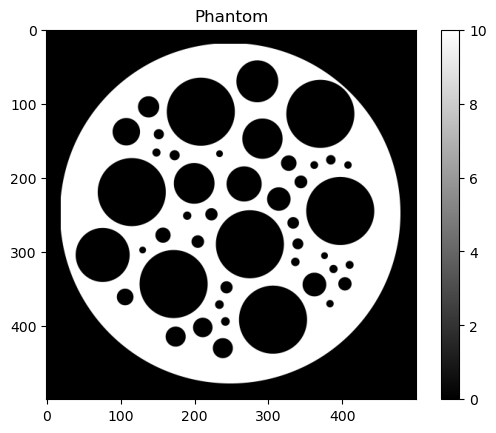

In [162]:
N_side = 500 # N_px = N_side**2
pitch = 1.  # m/px [can differ per axis]

seed = 0
# Generate phantom with xdesign
np.random.seed(seed)
p1 = xd.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
phantom = xd.discrete_phantom(p1, N_side-40) * 10
phantom = np.abs(np.pad(phantom, 20))

# phantom = np.zeros((N_side, N_side))
# phantom[N_side//2 - 1000:N_side//2 + 1000, N_side//2 - 1000:N_side//2 + 1000] = 1
arg_shape = phantom.shape

plt.figure('Phantom')
plt.imshow(phantom, cmap='gray')
plt.title('Phantom')
plt.colorbar()
plt.show()


# Parameters for the operator ==============================================================
N_angle  = 400 
N_offset = 400 

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False) + 1e-3

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.2  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom, dtype='float32')
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

In [163]:
# test fan beam
from tqdm import tqdm

# Simulation Parameters
N_angles = 400  # Number of projection angles
N_detectors = 400  # Number of detector elements

sdd = 100000.0  # Source-to-detector distance
sod = 0.6*sdd  # Source-to-object distance

angles = np.linspace(0, 2 * np.pi, N_angles, endpoint=False)

ray_t = np.zeros((N_angles * N_detectors, 2))  # Ray origin
ray_n = np.zeros((N_angles * N_detectors, 2))  # Ray direction

# Compute rays for each angle
for i in tqdm(range(N_angles)):
    theta = angles[i]
    
    # Compute source position (on a circular path)
    source = np.array([sod * np.cos(theta), sod * np.sin(theta)])

    # Define detector arc (equally spaced points)
    detector_offsets = np.linspace(-N_side/2, N_side/2, N_detectors)
    
    detector_x = detector_offsets * np.cos(theta + np.pi / 2)
    detector_y = detector_offsets * np.sin(theta + np.pi / 2)
    
    detectors = np.stack([detector_x, detector_y], axis=1)  # Shape: (N_detectors, 2)

    # Compute ray directions
    start_idx = i * N_detectors
    ray_t[start_idx:start_idx + N_detectors, :] = source + np.array([N_side/2, N_side/2])
    ray_n[start_idx:start_idx + N_detectors, :] = detectors - source  # Direction vectors
    
    # Normalize directions
    norm_factor = np.linalg.norm(ray_n[start_idx:start_idx + N_detectors], axis=1, keepdims=True)
    ray_n[start_idx:start_idx + N_detectors] /= norm_factor


# Convert to CuPy for GPU acceleration
t_spec = cp.array(ray_t)
n_spec = cp.array(ray_n)

print(t_spec.shape, n_spec.shape)

100%|██████████| 400/400 [00:00<00:00, 18173.88it/s]

(160000, 2) (160000, 2)


### Definition of the operators 
> X-ray transform with splines-basis functions of degree 0 (pixels), 1, or 2.

\begin{equation}
    \mathcal{P}_{\theta}\{f\}(s) = \int_{\mathbb{R}} f(t\theta + s\theta^\perp)\ \mathrm{d} t,
\end{equation}

In [164]:
t_spec = np.array(t_spec.get())
n_spec = np.array(n_spec.get())

op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

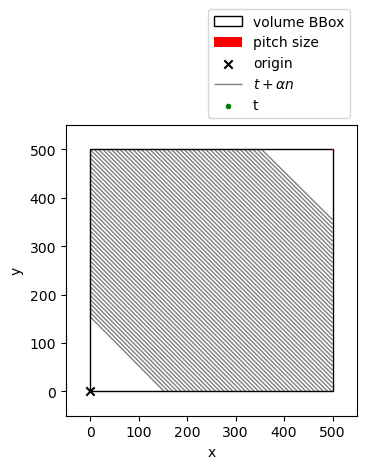

In [172]:
N, K = 5, 5

ray_idx = np.arange(N_angles * N_detectors).reshape(N_angles, N_detectors)[150,::K]

fig = op_pixels.diagnostic_plot(ray_idx)
fig.show()

## Compute the sinograms

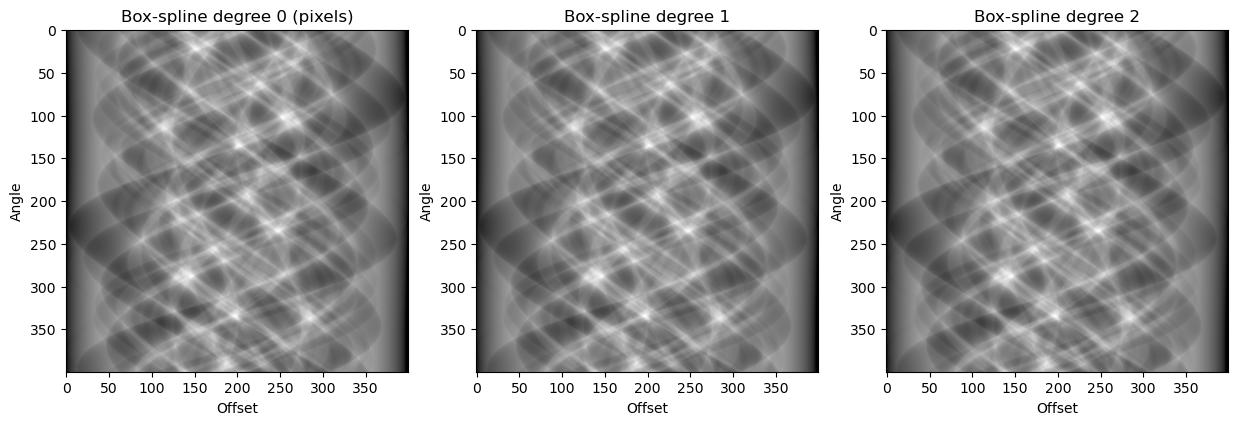

In [158]:
# projections for pixels, splines1 and splines2
projections_pixels = op_pixels(phantom.reshape(-1))
projections_splines_1 = op_splines_1(phantom.reshape(-1))
projections_splines_2 = op_splines_2(phantom.reshape(-1))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(projections_pixels.reshape(N_angle, N_offset).get(), cmap='gray')
axs[0].set_title('Box-spline degree 0 (pixels)')
axs[0].set_xlabel('Offset')
axs[0].set_ylabel('Angle')
axs[1].imshow(projections_splines_1.reshape(N_angle, N_offset).get(), cmap='gray')
axs[1].set_title('Box-spline degree 1')
axs[1].set_xlabel('Offset')
axs[1].set_ylabel('Angle')
axs[2].imshow(projections_splines_2.reshape(N_angle, N_offset).get(), cmap='gray')
axs[2].set_title('Box-spline degree 2')
axs[2].set_xlabel('Offset')
axs[2].set_ylabel('Angle')
plt.show()



/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
INFO:/tmp/pyxu_m34ehgb_:[2025-01-30 14:34:05.361457] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_m34ehgb_:[2025-01-30 14:34:05.628008] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_m34ehgb_:[2025-01-30 14:34:05.646669] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_m34ehgb_:[2025-01-30 14:34:05.665282] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_m34ehgb_:[2025-01-30 14:34:05.681805] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_m34ehgb_:[2025-01-30 14:34:05.698209] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_m34ehgb_:[2025-01-30 14:34:05.714331] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_m34ehgb_:[2025-01-30 14:34:05.730889] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_m34ehgb_:[2025-01-30 14:34:05

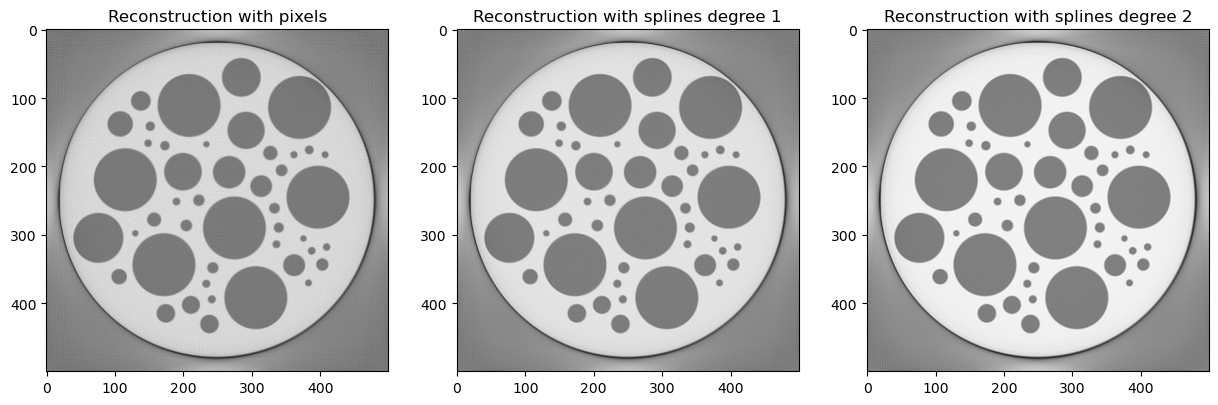

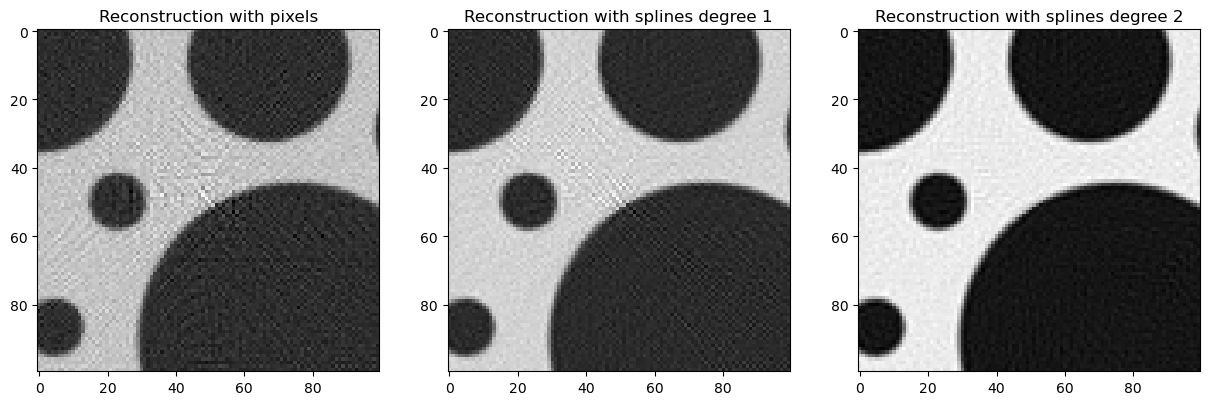

In [159]:
# reconstruction with pinv
stop_crit = pxst.MaxIter(30) #30 before

#enforce precision
rec_pixels = op_pixels.pinv(projections_pixels, damp=0.01, kwargs_fit=dict(stop_crit=stop_crit)).reshape(arg_shape).get()
rec_splines_1 = op_splines_1.pinv(projections_splines_1, damp=0.01, kwargs_fit=dict(stop_crit=stop_crit)).reshape(arg_shape).get()
rec_splines_2 = op_splines_2.pinv(projections_splines_2, damp=0.01, kwargs_fit=dict(stop_crit=stop_crit)).reshape(arg_shape).get()

#normalize
rec_pixels = (rec_pixels - cp.min(rec_pixels)) / (cp.max(rec_pixels) - cp.min(rec_pixels))
rec_splines_1 = (rec_splines_1 - cp.min(rec_splines_1)) / (cp.max(rec_splines_1) - cp.min(rec_splines_1))
rec_splines_2 = (rec_splines_2 - cp.min(rec_splines_2)) / (cp.max(rec_splines_2) - cp.min(rec_splines_2))
phantom = ((phantom - cp.min(phantom)) / (cp.max(phantom) - cp.min(phantom))).get()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(rec_pixels, cmap='gray')
axs[0].set_title('Reconstruction with pixels')
axs[1].imshow(rec_splines_1, cmap='gray')
axs[1].set_title('Reconstruction with splines degree 1')
axs[2].imshow(rec_splines_2, cmap='gray')
axs[2].set_title('Reconstruction with splines degree 2')
plt.show()

# zoom in
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(rec_pixels[200:300, 200:300], cmap='gray')
axs[0].set_title('Reconstruction with pixels')
axs[1].imshow(rec_splines_1[200:300, 200:300], cmap='gray')
axs[1].set_title('Reconstruction with splines degree 1')
axs[2].imshow(rec_splines_2[200:300, 200:300], cmap='gray')
axs[2].set_title('Reconstruction with splines degree 2')
plt.show()

In [20]:
# random ray going through the phantom
seed = 0
np.random.seed(seed)
n_spec  = cp.random.rand(N_angle, N_offset, 2) * 2 - 1
phantom = cp.array(phantom, dtype='float32')

In [21]:
op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

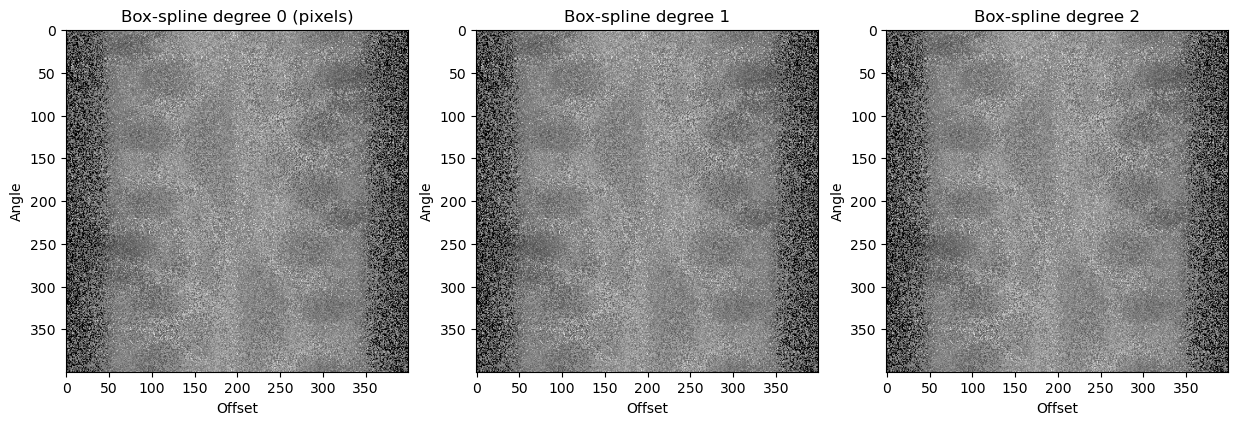

In [22]:
# projections for pixels, splines1 and splines2
projections_pixels = op_pixels(phantom.reshape(-1))
projections_splines_1 = op_splines_1(phantom.reshape(-1))
projections_splines_2 = op_splines_2(phantom.reshape(-1))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(projections_pixels.reshape(N_angle, N_offset).get(), cmap='gray')
axs[0].set_title('Box-spline degree 0 (pixels)')
axs[0].set_xlabel('Offset')
axs[0].set_ylabel('Angle')
axs[1].imshow(projections_splines_1.reshape(N_angle, N_offset).get(), cmap='gray')
axs[1].set_title('Box-spline degree 1')
axs[1].set_xlabel('Offset')
axs[1].set_ylabel('Angle')
axs[2].imshow(projections_splines_2.reshape(N_angle, N_offset).get(), cmap='gray')
axs[2].set_title('Box-spline degree 2')
axs[2].set_xlabel('Offset')
axs[2].set_ylabel('Angle')
plt.show()


INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.663570] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.687605] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.702179] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.716754] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.731666] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.746258] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.760937] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.775314] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.790784] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.805517] Iteration 9
	iteration: 9
	N_iter: 10.0


INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.820085] Iteration 10
	iteration: 10
	N_iter: 11.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.834747] Iteration 11
	iteration: 11
	N_iter: 12.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.849541] Iteration 12
	iteration: 12
	N_iter: 13.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.864368] Iteration 13
	iteration: 13
	N_iter: 14.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.879276] Iteration 14
	iteration: 14
	N_iter: 15.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.894132] Iteration 15
	iteration: 15
	N_iter: 16.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.909029] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.923833] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.938836] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.953465] Iteration 19
	iteration: 19
	N_iter: 20.0
INFO:/tmp/pyxu_0xa3fo6b:[2024-12-16 14:39:30.96816

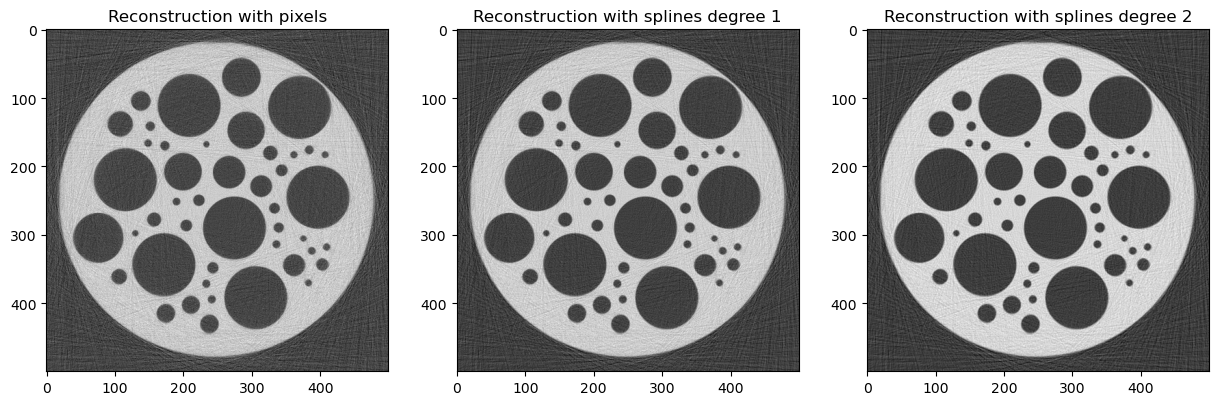

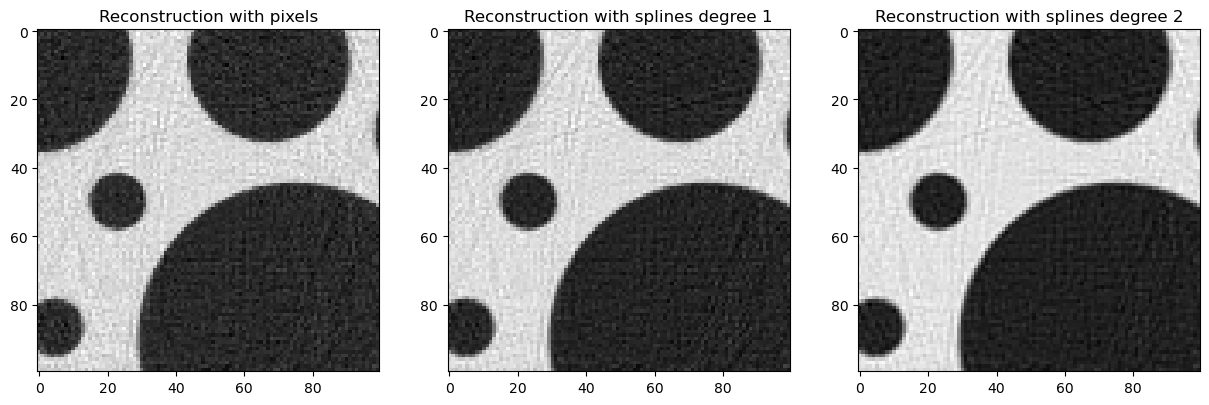

In [23]:
# reconstruction with pinv
stop_crit = pxst.MaxIter(30) #30 before

#enforce precision
rec_pixels = op_pixels.pinv(projections_pixels, damp=0.01, kwargs_fit=dict(stop_crit=stop_crit)).reshape(arg_shape).get()
rec_splines_1 = op_splines_1.pinv(projections_splines_1, damp=0.01, kwargs_fit=dict(stop_crit=stop_crit)).reshape(arg_shape).get()
rec_splines_2 = op_splines_2.pinv(projections_splines_2, damp=0.01, kwargs_fit=dict(stop_crit=stop_crit)).reshape(arg_shape).get()

#normalize
rec_pixels = (rec_pixels - cp.min(rec_pixels)) / (cp.max(rec_pixels) - cp.min(rec_pixels))
rec_splines_1 = (rec_splines_1 - cp.min(rec_splines_1)) / (cp.max(rec_splines_1) - cp.min(rec_splines_1))
rec_splines_2 = (rec_splines_2 - cp.min(rec_splines_2)) / (cp.max(rec_splines_2) - cp.min(rec_splines_2))
phantom = ((phantom - cp.min(phantom)) / (cp.max(phantom) - cp.min(phantom))).get()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(rec_pixels, cmap='gray')
axs[0].set_title('Reconstruction with pixels')
axs[1].imshow(rec_splines_1, cmap='gray')
axs[1].set_title('Reconstruction with splines degree 1')
axs[2].imshow(rec_splines_2, cmap='gray')
axs[2].set_title('Reconstruction with splines degree 2')
plt.show()

# zoom in
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(rec_pixels[200:300, 200:300], cmap='gray')
axs[0].set_title('Reconstruction with pixels')
axs[1].imshow(rec_splines_1[200:300, 200:300], cmap='gray')
axs[1].set_title('Reconstruction with splines degree 1')
axs[2].imshow(rec_splines_2[200:300, 200:300], cmap='gray')
axs[2].set_title('Reconstruction with splines degree 2')
plt.show()